In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

import matplotlib 
if not is_notebook():
    matplotlib.use('Agg')

In [2]:
import json
from functools import partial
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import submitit
from submitit.core.utils import CommandFunction
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt


from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments
from utils.utils import conf_to_args


In [3]:

# TODO: fix directory to create new directory each sweep but keep custom directory for each experiment
# TODO: also test writing slurm dirs to individusal experimetns
SCRIPT_NAME = "run_exp.py"
    

# Hyperparameter Sweeps

In [4]:
loss_configs = {
    "DivDis": {"loss_type": LossType.DIVDIS},
    # "TopK": {"loss_type": LossType.TOPK},
    "TopK 0.1": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1},
    "TopK 0.5": {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.5},
    "DBAT": {"loss_type": LossType.DBAT, "shared_backbone": False, "freeze_heads": True, "batch_size": 16, "target_batch_size": 32},
    "ERM": {"loss_type": LossType.ERM}
}

env_configs = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "batch_size": 32, "target_batch_size": 128},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "model": "Resnet50", "epochs": 10},
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": 10},
    "waterbirds": {"dataset": "waterbirds", "model": "Resnet50", "epochs": 10, "aggregate_mix_rate": True},
    "celebA-0": {"dataset": "celebA-0", "model": "Resnet50", "epochs": 10, "aggregate_mix_rate": True},
    # {"dataset": "multi-nli", "model": "bert", "epochs": 10, "lr": 1e-5}
}

mix_rates = [0.1, 0.5]

In [5]:
# maye need to move this to utils to pickle properly 
class ExperimentCommandFunction(CommandFunction):
    def __init__(self, script_name: str, conf: dict, metric: str, parent_dir: Path):
        self.conf = conf
        self.metric = metric
        self.parent_dir = parent_dir
        assert "exp_dir" not in conf, "exp_dir should not be in conf"
        super().__init__(["python", script_name] + conf_to_args(conf))
    
    def __call__(self, params: dict):
        # set exp dir 
        exp_dir = Path(self.parent_dir, "_".join([f"{k}-{v}" for k, v in params.items()]))
        # randomly generate seed 
        seed = np.random.randint(10000)
        # convert to args
        param_args = conf_to_args({**params, "exp_dir": exp_dir, "seed": seed})
        # run experiment 
        _result = super().__call__(*param_args) # relying on this to return only when the experiment is complete 
        # load metrics 
        with open(exp_dir / "metrics.json", "r") as f:
            metrics = json.load(f)
        # get metric value
        metric_val = metrics[self.metric]
        return metric_val

In [11]:
param_space = ng.p.Dict(
    lr=ng.p.Log(lower=1e-5, upper=1e-2),
    weight_decay=ng.p.Log(lower=1e-5, upper=1e-0),
    aux_weight=ng.p.Log(lower=1e0, upper=1e2),
    optimizer=ng.p.Choice(["sgd", "adamw"]), 
)

n_trials = 4 # TODO: 64
num_workers = 2 # TODO: 8
optimizer = ng.optimizers.RandomSearch(parametrization=param_space, budget=n_trials, num_workers=num_workers)

In [12]:
# TODO: specify validation split for each dataset (probably 10%?)
HPARM_PARENT_DIR = Path("output/subpopulation_hparam_sweep")
hparam_dir = Path(HPARM_PARENT_DIR, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
hparam_dir.mkdir(exist_ok=True, parents=True)

i = 0
for env_name, env_config in env_configs.items():
    for loss_name, loss_config in loss_configs.items():
        for mix_rate in mix_rates:
            if i >=1: # temporary
                break
            i += 1
            conf = {**env_config, **loss_config, "mix_rate": mix_rate}
            # TODO: remove
            conf["dataset_length"] = 128
            conf["epochs"] = 1

            sweep_dir = Path(hparam_dir, f"{env_name}_{loss_name}_{mix_rate}")
            executor = get_executor(sweep_dir)
            exp_cmd_func = ExperimentCommandFunction(SCRIPT_NAME, conf, "val_loss", sweep_dir)
            recommendation = optimizer.minimize(exp_cmd_func, executor=executor, batch_mode=True)
        # create directory for each experiment 

/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/nevergrad/common/tools.py:107: UserWarning: Ignoring since timer was stopped before starting.
  warnings.warn("Ignoring since timer was stopped before starting.")


In [16]:
for k, v in recommendation.value.items():
    print(f"{k}: {v}")

lr: 0.0036680481987059056
weight_decay: 0.013022726189466526
aux_weight: 17.41816882634615
optimizer: sgd


# Experiment Utils

In [ ]:
PARENT_RESULTS_DIR = Path("output/subpopulation_results")
load_last_results = False
new_results_dir = True


results_dir = Path(PARENT_RESULTS_DIR, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))



if load_last_results:
    results_dir = max(PARENT_RESULTS_DIR.iterdir(), key=lambda x: x.stat().st_ctime)  # most recent
elif new_results_dir:
    results_dir = Path(PARENT_RESULTS_DIR, datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))


results_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
@dataclass
class Experiment:
    seed: int
    loss_type: LossType
    model: str
    mix_rate: float
    mix_rate_lower_bound: float
    dataset: str
    source_cc: bool
    epochs: int
    lr: float
    batch_size: int 
    target_batch_size: int
    aux_weight: float = 1.0
    aggregate_mix_rate: bool = False
    shared_backbone: bool = True
    freeze_heads: bool = False
    exp_dir: Path = None
    
    def __post_init__(self):
        self.exp_dir = get_exp_dir(self)

def get_exp_dir(exp: Experiment):
    # last minute sweep
    conf_str = f"{exp.dataset}_{exp.loss_type.name}_{exp.model}_{exp.mix_rate}_{exp.mix_rate_lower_bound}_{exp.lr}_{exp.aux_weight}_{exp.epochs}_{exp.batch_size}_{exp.target_batch_size}"
    if not exp.shared_backbone:
        conf_str += "_shared_backbone_false"
    if exp.freeze_heads:
        conf_str += "_freeze_heads_true"
    if exp.aggregate_mix_rate:
        conf_str += "_aggregate_mix_rate_true"
    if not exp.source_cc:
        conf_str += "_source_cc_false"
    return Path(f"{results_dir}/{conf_str}/{exp.seed}")


# Experiments

In [6]:
def generate_experiments(env_configs: dict, loss_configs: list[dict], 
                        seeds: list[int], mix_rates: list[float]) -> list[Experiment]:
    experiments: list[Experiment] = []
    
    for seed in seeds:
        for loss_config in loss_configs:
            for env_config in env_configs.values():
                conf_mix_rates = mix_rates if loss_config["loss_type"] != LossType.ERM else [0.]
                for mix_rate in conf_mix_rates:
                    # Skip if mix_rate matches lower bound and no epochs specified
                    if ("epochs" not in loss_config and 
                        "mix_rate_lower_bound" in loss_config and 
                        loss_config["mix_rate_lower_bound"] == mix_rate):
                        continue 
                        
                    # Get overridable env configs
                    env_config_cp = deepcopy(env_config)
                    epochs = env_config_cp.pop("epochs")
                    batch_size = env_config_cp.pop("batch_size")
                    target_batch_size = env_config_cp.pop("target_batch_size")

                    # Override env configs with loss config
                    loss_config_cp = deepcopy(loss_config)
                    aggregate_mix_rate = env_config_cp.pop("aggregate_mix_rate", False)
                    aggregate_mix_rate = False if (not loss_config_cp['loss_type'] == LossType.TOPK) else aggregate_mix_rate
                    batch_size = loss_config_cp.pop("batch_size", batch_size)
                    target_batch_size = loss_config_cp.pop("target_batch_size", target_batch_size)
                    mix_rate_lower_bound = loss_config_cp.pop("mix_rate_lower_bound", mix_rate)
                    exp_epochs = loss_config_cp.pop("epochs", epochs)
                    source_cc = env_config_cp.pop("source_cc", True)
                    
                    exp = Experiment(
                        seed=seed, **loss_config_cp, **env_config_cp, mix_rate=mix_rate, 
                        mix_rate_lower_bound=mix_rate_lower_bound, epochs=exp_epochs, 
                        batch_size=batch_size, target_batch_size=target_batch_size,
                        aggregate_mix_rate=aggregate_mix_rate, source_cc=source_cc
                    )
                    experiments.append(exp)
                    
    return experiments

In [7]:
# num_seeds = 5
num_seeds = 3
seeds = [i for i in range(num_seeds)]

EPOCHS = 10 
BS = 32
TARGET_BS = 64

In [8]:
# var mix rate experiments
loss_configs = [ 
    {"loss_type": LossType.DIVDIS},
    {"loss_type": LossType.DIVDIS, "aux_weight": 10.0},
    {"loss_type": LossType.TOPK},
    {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1}, 
    {"loss_type": LossType.DBAT, "shared_backbone": False, "freeze_heads": True, "batch_size": int(BS / 2), "target_batch_size": int(TARGET_BS / 2)},
    {"loss_type": LossType.ERM}
    # {"loss_type": LossType.EXP}
]

mix_rate_env_configs = {
    "toy_grid": {"dataset": "toy_grid", "model": "toy_model", "epochs": 100, "lr": 1e-3, "batch_size": BS, "target_batch_size": 128},
    "fmnist_mnist": {"dataset": "fmnist_mnist", "model": "Resnet50", "epochs": 10, "lr": 1e-4, "batch_size": BS, "target_batch_size": TARGET_BS},
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": 10, "lr": 1e-4, "batch_size": BS, "target_batch_size": TARGET_BS},
    "waterbirds": {"dataset": "waterbirds", "model": "Resnet50", "epochs": 10, "lr": 1e-4, "aggregate_mix_rate": True, "batch_size": BS, "target_batch_size": TARGET_BS},
    "celebA-0": {"dataset": "celebA-0", "model": "Resnet50", "epochs": 10, "lr": 1e-4, "aggregate_mix_rate": True, "batch_size": BS, "target_batch_size": TARGET_BS},
    # {"dataset": "multi-nli", "model": "bert", "epochs": 10, "lr": 1e-5}
    
}

mix_rates = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
experiments = generate_experiments(mix_rate_env_configs, loss_configs, seeds, mix_rates)

In [9]:
# more epochs on complete correlation experiments 
MORE_EPOCHS = 50
loss_configs = [ 
    {"loss_type": LossType.DIVDIS},
    {"loss_type": LossType.DIVDIS, "aux_weight": 10.0},
    {"loss_type": LossType.TOPK},
    {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1}, 
    {"loss_type": LossType.DBAT, "shared_backbone": False, "freeze_heads": True, "batch_size": int(BS / 2), "target_batch_size": int(TARGET_BS / 2)},
    # {"loss_type": LossType.EXP}
]

more_epochs_env_configs = {
    "fmnist_mnist": {"dataset": "fmnist_mnist", "model": "Resnet50", "epochs": MORE_EPOCHS, "lr": 1e-4, "batch_size": BS, "target_batch_size": TARGET_BS},
    "cifar_mnist": {"dataset": "cifar_mnist", "model": "Resnet50", "epochs": MORE_EPOCHS, "lr": 1e-4, "batch_size": BS, "target_batch_size": TARGET_BS},
}

more_epochs_experiments = generate_experiments(more_epochs_env_configs, loss_configs, seeds, mix_rates)

In [10]:
# real data (incomplete spurious correlation) experiments

real_loss_configs = [ 
    {"loss_type": LossType.DIVDIS},
    {"loss_type": LossType.DIVDIS, "aux_weight": 10.0},
    {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1}, 
    {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.5}, 
    {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 1.0}, 
    {"loss_type": LossType.DBAT, "shared_backbone": False, "freeze_heads": True, "batch_size": int(BS / 2), "target_batch_size": int(TARGET_BS / 2)},
    {"loss_type": LossType.ERM}
]

real_env_configs = {
    "waterbirds": {"dataset": "waterbirds", "source_cc": False, "model": "Resnet50", "epochs": 10, "lr": 1e-4, "aggregate_mix_rate": True, "batch_size": BS, "target_batch_size": TARGET_BS},
    # NOTE: was 3 epochs
    "camelyon": {"dataset": "camelyon", "source_cc": False, "model": "Resnet50", "epochs": 10, "lr": 1e-4, "aggregate_mix_rate": True, "batch_size": BS, "target_batch_size": TARGET_BS},
    # "celebA-0": {"dataset": "celebA-0", "source_cc": False, "model": "Resnet50", "epochs": 10, "lr": 1e-4, "aggregate_mix_rate": True, "batch_size": BS, "target_batch_size": TARGET_BS},
    # "multi-nli": {"dataset": "multi-nli", "source_cc": False, "model": "bert", "epochs": 10, "lr": 1e-5}
}


real_env_experiments = generate_experiments(real_env_configs, real_loss_configs, seeds, [None])

# Run Experiments

## Mix Rate Experiments

In [8]:
# new_experiments  = [exp for exp in experiments if not os.path.exists(exp.exp_dir / "metrics.json")]

In [25]:
out_dir = Path(f"output_logs/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
out_dir.mkdir(exist_ok=True, parents=True)

executor = get_executor(out_dir)
jobs = run_experiments(executor, experiments, SCRIPT_NAME)



/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [1]:
print(jobs[0].stderr())
print(jobs[0].stdout())


NameError: name 'jobs' is not defined

## Realistic Data (Source not CC) Experiments

In [11]:
len(real_env_experiments)

42

In [86]:
out_dir = Path(f"output_logs/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
out_dir.mkdir(exist_ok=True, parents=True)

executor = get_executor(out_dir)
jobs = run_experiments(executor, real_env_experiments, SCRIPT_NAME)

/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [87]:
print(jobs[0].stderr())
print(jobs[0].stdout())



submitit INFO (2024-12-10 20:03:17,716) - Starting with JobEnvironment(job_id=743236_0, hostname=gan.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-12-10 20:03:17,716) - Loading pickle: /nas/ucb/oliveradk/diverse-gen/output_logs/2024-12-10_20-03-16/743236_0_submitted.pkl
The following command is sent: "python run_exp.py seed=0 loss_type=DIVDIS model=Resnet50 mix_rate=null mix_rate_lower_bound=null dataset=camelyon source_cc=False epochs=10 lr=0.0001 batch_size=32 target_batch_size=64 aux_weight=1.0 aggregate_mix_rate=False shared_backbone=True freeze_heads=False exp_dir=output/last_minute_sweep/camelyon_DIVDIS_Resnet50_None_None_0.0001_1.0_10_32_64_source_cc_false/0"



## More Epochs Experiments

In [50]:
out_dir = Path(f"output_logs/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
out_dir.mkdir(exist_ok=True, parents=True)

executor = get_executor(out_dir)
jobs = run_experiments(executor, more_epochs_experiments, SCRIPT_NAME)



/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")
/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'exclude' is deprecated. Use 'slurm_exclude' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [51]:
print(jobs[0].stderr())
print(jobs[0].stdout())


submitit INFO (2024-12-10 09:27:28,379) - Starting with JobEnvironment(job_id=742799_0, hostname=ppo.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-12-10 09:27:28,379) - Loading pickle: /nas/ucb/oliveradk/diverse-gen/output_logs/2024-12-10_09-27-27/742799_0_submitted.pkl
The following command is sent: "python run_exp.py seed=0 loss_type=DIVDIS model=Resnet50 mix_rate=0.1 mix_rate_lower_bound=0.1 dataset=fmnist_mnist source_cc=True epochs=50 lr=0.0001 batch_size=32 target_batch_size=64 aux_weight=1.0 aggregate_mix_rate=False shared_backbone=True freeze_heads=False exp_dir=output/last_minute_sweep/fmnist_mnist_DIVDIS_Resnet50_0.1_0.1_0.0001_1.0_50_32_64/0"



# Process Results

In [11]:
RESULT_DIR = Path("output/results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)


In [12]:
from typing import Literal
def get_exp_metrics(exp: Experiment):
    if not (exp.exp_dir / "metrics.json").exists():
        raise FileNotFoundError(f"Metrics file not found for experiment {exp.exp_dir}")
    with open(exp.exp_dir / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics

def get_max_acc(
        exp_metrics: dict,
        model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc"
    ):
    max_accs = np.maximum(np.array(exp_metrics['epoch_acc_0']), np.array(exp_metrics['epoch_acc_1']))
    if model_selection == "acc": 
        max_acc_idx= np.argmax(max_accs)
    elif model_selection == "loss":
        max_acc_idx = np.argmin(exp_metrics["val_loss"])
    elif model_selection == "weighted_loss":
        max_acc_idx = np.argmin(exp_metrics["val_weighted_loss"])
    elif model_selection == "repulsion_loss":
        max_acc_idx = np.argmin(exp_metrics["target_val_weighted_repulsion_loss"])
    else: 
        raise ValueError(f"Invalid model selection: {model_selection}")
    max_acc = max_accs[max_acc_idx]
    return max_acc


In [13]:
# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results(
    experiments: list[Experiment], 
    model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc",
):
    results = defaultdict(list)
    for exp in experiments:
        try:
            exp_metrics = get_exp_metrics(exp)
            max_acc = get_max_acc(exp_metrics, model_selection)
            results[exp.mix_rate].append(max_acc)
        except FileNotFoundError:
            print(f"Metrics file not found for experiment {exp.exp_dir}")
            continue
    results = dict(results)
    return results


In [14]:
# group by dataset 
# then group by loss config 
# TODO: fix this to automatically use aggegrate mix rate according to the env config (need to run those experiments first thought)
def experiments_by_loss_config(experiments: list[Experiment], env_configs: dict):
    # divdis aux weight 1 
    divdis_aux_weight_1_experiments = [
        exp for exp in experiments if exp.loss_type == LossType.DIVDIS and 
        exp.aux_weight == 1.0 and 
        exp.epochs == env_configs[exp.dataset]["epochs"]
    ]
    # divdis aux weight 10 
    divdis_aux_weight_10_experiments = [
        exp for exp in experiments if exp.loss_type == LossType.DIVDIS and 
        exp.aux_weight == 10.0 and 
        exp.epochs == env_configs[exp.dataset]["epochs"]
    ]
    # topk mix rate lower bound 0.1 
    topk_mix_rate_lower_bound_01_experiments = [
        exp for exp in experiments 
        if exp.loss_type == LossType.TOPK and 
        exp.mix_rate_lower_bound == 0.1 and 
        (exp.aggregate_mix_rate == env_configs[exp.dataset].get("aggregate_mix_rate", False)) and 
        exp.epochs == env_configs[exp.dataset]["epochs"]
    ]
    # topk 
    topk_experiments = [
        exp for exp in experiments 
        if exp.loss_type == LossType.TOPK and 
        exp.mix_rate == exp.mix_rate_lower_bound and 
        (exp.aggregate_mix_rate == env_configs[exp.dataset].get("aggregate_mix_rate", False)) and 
        exp.epochs == env_configs[exp.dataset]["epochs"]
    ]
    # dbat
    dbat_experiments = [
        exp for exp in experiments if exp.loss_type == LossType.DBAT and 
        exp.epochs == env_configs[exp.dataset]["epochs"]
    ]
    # erm 
    erm_experiments = [
        exp for exp in experiments if exp.loss_type == LossType.ERM and 
        exp.epochs == env_configs[exp.dataset]["epochs"]
    ]
    
    exp_dict = {
        "DivDis": divdis_aux_weight_1_experiments, 
        "DivDis 10": divdis_aux_weight_10_experiments, 
        "DBAT": dbat_experiments,
        "TopK": topk_experiments,
        "TopK 0.1": topk_mix_rate_lower_bound_01_experiments, 
        "ERM": erm_experiments
    }

    return exp_dict


In [15]:
FIGSIZE = (3., 2.5)
FONTSIZE = 12
TICK_FONTSIZE = 10

def plot_acc_results(
    results: dict, ignored_loss_types: list[str]=[], 
    figsize: tuple[float, float]=FIGSIZE,
    ylim: tuple[float, float]=(0.5, 1.0), 
    title: Optional[str]=None, 
    fontsize: int=FONTSIZE,
    tick_fontsize: int=TICK_FONTSIZE,
    legend: bool=False
):
    # plot mean accuracy with dotted standard deviation for each method type at each mix rate
    fig, ax = plt.subplots(figsize=figsize)
    
    for loss_type, loss_results in results.items():
        if loss_type in ignored_loss_types:
            continue
        
        if isinstance(loss_type, LossType):
            loss_type = loss_type.name 
        
        if loss_type == LossType.ERM.name:
            means = [np.mean(loss_results[0.0]) for _ in mix_rates]
            stds = [np.std(loss_results[0.0]) for _ in mix_rates]
            # dotted line 
            line_style = '--'
            marker = None
        else:
            means = [np.mean(loss_results[mix_rate]) for mix_rate in mix_rates]
            stds = [np.std(loss_results[mix_rate]) for mix_rate in mix_rates]
            line_style = '-'
            marker = 'o'
        
        ax.plot(mix_rates, means, label=loss_type, marker=marker, linestyle=line_style)
        ax.fill_between(mix_rates, 
                        [m - s for m, s in zip(means, stds)],
                        [m + s for m, s in zip(means, stds)],
                        alpha=0.2)

    # ax.set_xlabel('Mix Rate', fontsize=fontsize)
    # ax.set_ylabel('Accuracy', fontsize=fontsize)

    # set x ticks to mix rates
    x_labels = ['0.1', '0.25', '0.5', '0.75', '0.9', '1']
    ax.set_xticks(mix_rates)
    ax.set_xticklabels(x_labels, fontsize=tick_fontsize)

    # tick fontsize
    ax.tick_params(axis='both', labelsize=tick_fontsize)


    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    if legend:
        ax.legend()
    # ax.grid(True, linestyle='--', alpha=0.7)
    # start y axis at 0.75
    ax.set_ylim(*ylim)

    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # remove bottom and left spines
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    fig.tight_layout()
    return fig, ax


## Accuracy Across Mix Rates 

In [30]:
cifar_experiments = [exp for exp in experiments if exp.dataset == "cifar_mnist"]
fmnist_experiments = [exp for exp in experiments if exp.dataset == "fmnist_mnist"]
toy_grid_experiments = [exp for exp in experiments if exp.dataset == "toy_grid"]
waterbirds_experiments = [exp for exp in experiments if exp.dataset == "waterbirds"]
celebA_experiments = [exp for exp in experiments if exp.dataset == "celebA-0"]


cifar_exp_by_loss_config = experiments_by_loss_config(cifar_experiments, mix_rate_env_configs)
fmnist_exp_by_loss_config = experiments_by_loss_config(fmnist_experiments, mix_rate_env_configs)
toy_grid_exp_by_loss_config = experiments_by_loss_config(toy_grid_experiments, mix_rate_env_configs)
waterbirds_exp_by_loss_config = experiments_by_loss_config(waterbirds_experiments, mix_rate_env_configs)
celebA_exp_by_loss_config = experiments_by_loss_config(celebA_experiments, mix_rate_env_configs)

In [38]:
model_selection = "loss" 
cifar_results = {k: get_acc_results(v, model_selection=model_selection) for k, v in cifar_exp_by_loss_config.items()}
fmnist_results = {k: get_acc_results(v, model_selection=model_selection) for k, v in fmnist_exp_by_loss_config.items()}
toy_grid_results = {k: get_acc_results(v, model_selection=model_selection) for k, v in toy_grid_exp_by_loss_config.items()}
waterbirds_results = {k: get_acc_results(v, model_selection=model_selection) for k, v in waterbirds_exp_by_loss_config.items()}
celebA_results = {k: get_acc_results(v, model_selection=model_selection) for k, v in celebA_exp_by_loss_config.items()}


In [32]:
VAR_MIX_RATE_DIR = RESULT_DIR / "var_mix_rate"
VAR_MIX_RATE_DIR.mkdir(exist_ok=True, parents=True)


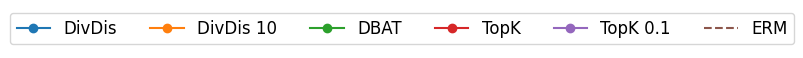

In [43]:
current_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(figsize=(8, 0.5))
legend_elements = [
    plt.Line2D([0], [0], color=current_colors[i], marker='o' if k != "ERM" else None, linestyle='-' if k != "ERM" else '--', label=k) 
    for i, k in enumerate(cifar_results.keys())
]

ax.set_axis_off()


plt.figlegend(handles=legend_elements,
              ncol=len(cifar_results.keys()),
             loc='center',
             bbox_to_anchor=(0.5, 0.5),
             fontsize=12,
             frameon=True)
# save legend 
fig.savefig(VAR_MIX_RATE_DIR / "legend.svg", format="svg", bbox_inches="tight", dpi=300)
# fig.savefig(RESULT_DIR / "legend.png", format="png", bbox_inches="tight", dpi=300)


In [34]:
toy_grid_results["ERM"]

{0.0: [0.7639999985694885, 0.7879999876022339, 0.6859999895095825]}

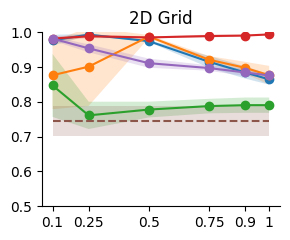

In [46]:
fig, ax = plot_acc_results(
    toy_grid_results, ignored_loss_types=["TopK 0.1 50"], title="2D Grid", ylim=(0.5, 1.0)
)
fig.savefig(VAR_MIX_RATE_DIR / "toy_grid_results.svg", format="svg", bbox_inches="tight", dpi=300)

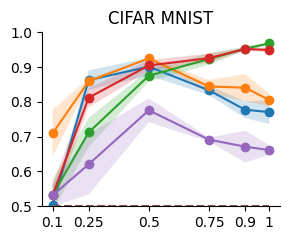

In [47]:
fig, ax = plot_acc_results(cifar_results, title="CIFAR MNIST")
fig.savefig(VAR_MIX_RATE_DIR / "cifar_results.svg", format="svg", bbox_inches="tight", dpi=300)

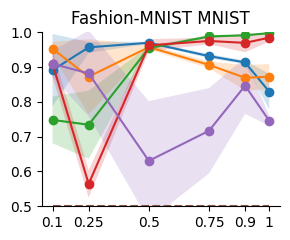

In [48]:
fig, ax = plot_acc_results(fmnist_results, ylim=(0.5, 1.0), title="Fashion-MNIST MNIST")
fig.savefig(VAR_MIX_RATE_DIR / "fmnist_results.svg", format="svg", bbox_inches="tight", dpi=300)


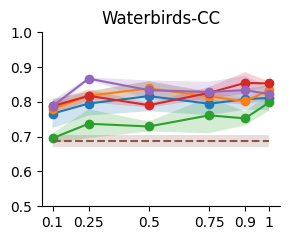

In [49]:
fig, ax = plot_acc_results(waterbirds_results, title="Waterbirds-CC", ylim=(0.5, 1.0))
# fig.savefig(VAR_MIX_RATE_DIR / "waterbirds_results.png", format="png", bbox_inches="tight", dpi=300)
fig.savefig(VAR_MIX_RATE_DIR / "waterbirds_results.svg", format="svg", bbox_inches="tight", dpi=300)

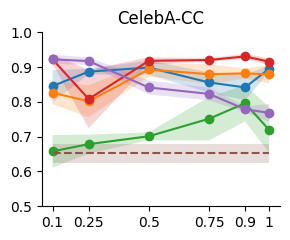

In [50]:
fig, ax = plot_acc_results(celebA_results, title="CelebA-CC", ylim=(0.5, 1.0))
fig.savefig(VAR_MIX_RATE_DIR / "celebA_results.svg", format="svg", bbox_inches="tight", dpi=300)


###  Alt Label Accuracy (especially for waterbirds, celebA, 2D grid)

##  Accuracy on More Epochs (Strong Bias) Experiments

In [36]:
cifar_more_epochs_experiments = [exp for exp in more_epochs_experiments if exp.dataset == "cifar_mnist"]
fmnist_more_epochs_experiments = [exp for exp in more_epochs_experiments if exp.dataset == "fmnist_mnist"]

cifar_more_epochs_exp_by_loss_config = experiments_by_loss_config(cifar_more_epochs_experiments, more_epochs_env_configs)
fmnist_more_epochs_exp_by_loss_config = experiments_by_loss_config(fmnist_more_epochs_experiments, more_epochs_env_configs)


cifar_more_epochs_results = {k: get_acc_results(v, model_selection="loss") for k, v in cifar_more_epochs_exp_by_loss_config.items()}
fmnist_more_epochs_results = {k: get_acc_results(v, model_selection="loss") for k, v in fmnist_more_epochs_exp_by_loss_config.items()}



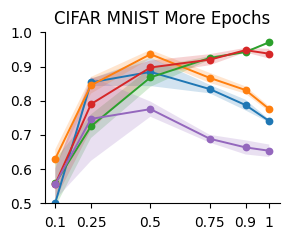

In [38]:
fig, ax = plot_acc_results(cifar_more_epochs_results, title="CIFAR MNIST More Epochs")
fig

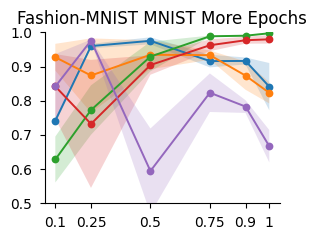

In [39]:
fig, ax = plot_acc_results(fmnist_more_epochs_results, title="Fashion-MNIST MNIST More Epochs")
fig


## Accuracy on Incomplete Correlation Experiments

In [16]:
def real_env_experiments_by_loss_config(experiments: list[Experiment], env_configs: dict):
    divdis_aux_weight_1_experiments = [exp for exp in experiments if exp.loss_type == LossType.DIVDIS and exp.aux_weight == 1.0]
    divdis_aux_weight_10_experiments = [exp for exp in experiments if exp.loss_type == LossType.DIVDIS and exp.aux_weight == 10.0]
    dbat_experiments = [exp for exp in experiments if exp.loss_type == LossType.DBAT]
    topk_01_experiments = [exp for exp in experiments if exp.loss_type == LossType.TOPK and exp.mix_rate_lower_bound == 0.1 and exp.epochs == env_configs[exp.dataset]["epochs"]]
    topk_05_experiments = [exp for exp in experiments if exp.loss_type == LossType.TOPK and exp.mix_rate_lower_bound == 0.5 and exp.epochs == env_configs[exp.dataset]["epochs"]]
    topk_10_experiments = [exp for exp in experiments if exp.loss_type == LossType.TOPK and exp.mix_rate_lower_bound == 1.0 and exp.epochs == env_configs[exp.dataset]["epochs"]]
    erm_experiments = [exp for exp in experiments if exp.loss_type == LossType.ERM and exp.epochs == env_configs[exp.dataset]["epochs"]]
    return {
        "DivDis": divdis_aux_weight_1_experiments, 
        "DivDis 10": divdis_aux_weight_10_experiments, 
        "DBAT": dbat_experiments,
        "TopK 0.1": topk_01_experiments,
        "TopK 0.5": topk_05_experiments,
        "TopK 1.0": topk_10_experiments, 
        "ERM": erm_experiments
    }


In [17]:
waterbirds_experiments = [exp for exp in real_env_experiments if exp.dataset == "waterbirds"]
camelyon_experiments = [exp for exp in real_env_experiments if exp.dataset == "camelyon"]

waterbirds_exp_by_loss_config = real_env_experiments_by_loss_config(waterbirds_experiments, real_env_configs)
camelyon_exp_by_loss_config = real_env_experiments_by_loss_config(camelyon_experiments, real_env_configs)

waterbirds_results_loss_selection = {k: get_acc_results(v, model_selection="loss") for k, v in waterbirds_exp_by_loss_config.items()}
waterbirds_results_acc_selection = {k: get_acc_results(v, model_selection="acc") for k, v in waterbirds_exp_by_loss_config.items()}

camelyon_results_loss_selection = {k: get_acc_results(v, model_selection="loss") for k, v in camelyon_exp_by_loss_config.items()}
camelyon_results_acc_selection = {k: get_acc_results(v, model_selection="acc") for k, v in camelyon_exp_by_loss_config.items()}



In [18]:
import pandas as pd
import numpy as np

def results_to_table(results: dict, sort: bool=False) -> pd.DataFrame:
    rows = []
    for method, mix_rate_dict in results.items():
        # Since there's only one mix_rate (None) in this case
        
        accuracies = next(iter(mix_rate_dict.values()))
        rows.append({
            'Method': method,
            'Mean': np.mean(accuracies),
            'Std': np.std(accuracies),
        })
    
    # Create DataFrame and sort by mean accuracy
    df = pd.DataFrame(rows)
    if sort:
        df = df.sort_values('Mean', ascending=False)

    # multiply each result by 100
    df['Mean'] = df['Mean'] * 100
    df['Std'] = df['Std'] * 100
    
    # Format the numbers to have fewer decimal places
    df['Mean'] = df['Mean'].map('{:.1f}'.format)
    df['Std'] = df['Std'].map('{:.1f}'.format)
    
    return df

In [19]:
def merge_results_tables(results_dict_loss: dict[str, dict], 
                        results_dict_acc: dict[str, dict]) -> pd.DataFrame:
    """
    Merge multiple results tables into a single DataFrame with methods as index
    and datasets as columns, showing both loss and accuracy selection results.
    
    Args:
        results_dict_loss: Dictionary mapping dataset names to their loss-selection results
        results_dict_acc: Dictionary mapping dataset names to their accuracy-selection results
        
    Returns:
        pd.DataFrame: Merged table with methods as index and datasets as columns (loss/acc)
    """

    
    # First convert each dataset's results to a table
    dataset_tables_loss = {
        dataset: results_to_table(results)
        for dataset, results in results_dict_loss.items()
    }
    dataset_tables_acc = {
        dataset: results_to_table(results)
        for dataset, results in results_dict_acc.items()
    }

   
    # Create empty DataFrame with methods as index
    methods = sorted(set().union(
        *(df['Method'] for df in dataset_tables_loss.values()),
        *(df['Method'] for df in dataset_tables_acc.values())
    ))
    merged_df = pd.DataFrame(index=methods)
    
    # Fill in values for each dataset
    for dataset in results_dict_loss.keys():
        # Loss selection results
        df_loss = dataset_tables_loss[dataset]
        values_loss = df_loss.set_index('Method').apply(
            lambda row: f"{row['Mean']} ± {row['Std']}", 
            axis=1
        )
        merged_df[f"{dataset} (loss)"] = values_loss
        
        # Accuracy selection results
        df_acc = dataset_tables_acc[dataset]
        values_acc = df_acc.set_index('Method').apply(
            lambda row: f"{row['Mean']} ± {row['Std']}", 
            axis=1
        )
        merged_df[f"{dataset} (acc)"] = values_acc
    
    return merged_df

# Example usage:
results_dict_loss = {
    'Waterbirds': waterbirds_results_loss_selection,
    'Camelyon': camelyon_results_loss_selection
}
results_dict_acc = {
    'Waterbirds': waterbirds_results_acc_selection,
    'Camelyon': camelyon_results_acc_selection
}

# convert results to
merged_table = merge_results_tables(results_dict_loss, results_dict_acc)
merged_table

,Waterbirds (loss),Waterbirds (acc),Camelyon (loss),Camelyon (acc)
DBAT,89.3 ± 0.7,91.3 ± 0.8,90.1 ± 2.5,93.5 ± 0.8
DivDis,88.5 ± 1.0,89.4 ± 0.4,83.5 ± 5.9,87.8 ± 1.4
DivDis 10,87.3 ± 1.0,88.9 ± 0.8,85.3 ± 3.7,88.5 ± 3.9
ERM,87.9 ± 0.2,91.6 ± 1.0,87.9 ± 3.7,94.1 ± 1.1
TopK 0.1,90.6 ± 0.5,92.0 ± 0.2,90.7 ± 2.6,94.1 ± 0.7
TopK 0.5,86.8 ± 3.4,90.7 ± 2.4,79.4 ± 9.1,91.3 ± 2.9
TopK 1.0,83.5 ± 1.6,85.7 ± 2.1,87.1 ± 5.8,92.1 ± 1.9


In [80]:
print(merged_table.to_latex())

\begin{tabular}{lllll}
\toprule
 & Waterbirds (loss) & Waterbirds (acc) & Camelyon (loss) & Camelyon (acc) \\
\midrule
DBAT & 89.3 ± 0.7 & 91.3 ± 0.8 & 87.6 ± 5.1 & 92.4 ± 2.3 \\
DivDis & 88.5 ± 1.0 & 89.4 ± 0.4 & 79.7 ± 4.9 & 85.2 ± 5.1 \\
DivDis 10 & 87.3 ± 1.0 & 88.9 ± 0.8 & 83.3 ± 5.3 & 86.4 ± 1.5 \\
ERM & 87.9 ± 0.2 & 91.6 ± 1.0 & 87.4 ± 5.9 & 91.0 ± 4.0 \\
TopK 0.1 & 90.6 ± 0.5 & 92.0 ± 0.2 & 90.6 ± 2.1 & 93.2 ± 2.1 \\
TopK 0.5 & 86.8 ± 3.4 & 90.7 ± 2.4 & 85.7 ± 9.5 & 91.5 ± 1.4 \\
TopK 1.0 & 83.5 ± 1.6 & 85.7 ± 2.1 & 78.3 ± 9.8 & 88.6 ± 3.1 \\
\bottomrule
\end{tabular}



##  Accuracy over Epochs

In [ ]:
# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results_over_epochs(
    experiments: list[Experiment], 
    lower_bound: Optional[float]=None
):
    results = defaultdict(lambda: defaultdict(list))
    for exp in experiments:
        if lower_bound is not None and exp.mix_rate_lower_bound != lower_bound:
            continue
        elif lower_bound is None:
            if exp.mix_rate != exp.mix_rate_lower_bound:
                continue
        exp_metrics = get_exp_metrics(exp)
        # take max over epoch_acc_0, epoch_acc_1
        max_acc = np.maximum(np.array(exp_metrics['epoch_acc_0']), np.array(exp_metrics['epoch_acc_1']))
        results[exp.loss_type][exp.mix_rate].append(max_acc)
    results = {k: dict(v) for k, v in results.items()}
    return results

results_acc_over_epochs = get_acc_results_over_epochs(experiments)

In [ ]:
mix_rate = 0.5 

for loss_type, loss_type_acc_over_epochs in results_acc_over_epochs.items():
    # compute mean and std over seeds
    mean_acc_over_epochs = np.mean(loss_type_acc_over_epochs[mix_rate], axis=0)
    std_acc_over_epochs = np.std(loss_type_acc_over_epochs[mix_rate], axis=0)
    plt.plot(mean_acc_over_epochs, label=f"{loss_type.name}")
    plt.fill_between(range(len(mean_acc_over_epochs)), 
                     mean_acc_over_epochs - std_acc_over_epochs,
                     mean_acc_over_epochs + std_acc_over_epochs,
                     alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()